In [47]:
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip, RandomRotation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.metrics import BinaryCrossentropy as metricBinaryCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow import cast, expand_dims, float32
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [48]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Import data and labels


In [49]:
data_path = './blind_cameras_dataset'
#neutrino-01 path: '/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-OPTICALSIM-PROD/GRAIN/blindcam/data'
  
with open(data_path+'/simulation.npy', 'rb') as f:    #'+str(sim_num)+'
    data_in = np.load(f)
with open(data_path+'/inner_ph.npy', 'rb') as g:      #'+str(sim_num)+'
    inner_ph_in = np.load(g)
### Preprocessing

### Preprocessing

In [50]:
###### parameters #################
root_threshold = 10
###### fixed parameters ###########
n_cam_in_grain = 54
cam_side_length = 31
renormalisation = 10000
###################################

data = (data_in).reshape(-1, n_cam_in_grain, cam_side_length**2)
print('data shape (n_data, n_cam, cam_shape) :',data.shape)

print('\n' + '################ process data from root file ################') 
  
inner_ph = inner_ph_in.reshape(n_cam_in_grain, -1)    #inner_ph_in.reshape(76,-1)  
print('inner photons shape :',inner_ph.shape)
  
overthr_inner_evn = np.unique( np.where( inner_ph > root_threshold )[1] )
label = np.zeros(inner_ph_in.size).reshape(-1, n_cam_in_grain)

for evn in overthr_inner_evn:
    for cam in np.unique( np.where( inner_ph.T[evn] > root_threshold ) ):
        label[evn][cam] = 1
print('labelled blind :', np.where(label==1)[0].size)

data shape (n_data, n_cam, cam_shape) : (1000, 54, 961)

################ process data from root file ################
inner photons shape : (54, 1000)
labelled blind : 742


#### Apply RobustScaler

In [51]:
# scaler_ = RobustScaler().fit(data_in.reshape(cam_side_length**2,-1))
# scaler_data = scaler_.transform(data_in.reshape(cam_side_length**2,-1)).reshape(-1, n_cam_in_grain, cam_side_length**2)

In [52]:
normalize_ = np.max(data.reshape(-1, cam_side_length**2), axis = 1)
normalize_data = (data.reshape(-1, cam_side_length**2) / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, n_cam_in_grain, cam_side_length**2)
normalize_data.shape

C:\Users\Pc\AppData\Local\Temp\ipykernel_35852\4262946079.py:2: RuntimeWarning: invalid value encountered in divide
  normalize_data = (data.reshape(-1, cam_side_length**2) / (normalize_.reshape(-1,1)*np.ones((1, cam_side_length**2)))).reshape(-1, n_cam_in_grain, cam_side_length**2)


(1000, 54, 961)

#### Split into test and training sets

In [62]:
train_data, test_data = normalize_data[:800], normalize_data[800:]
train_label, test_label = label[:800], label[800:]

train_data.shape

(800, 54, 961)

In [63]:
train_data.shape

(800, 54, 961)

In [64]:
train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data.reshape(-1, cam_side_length, cam_side_length, 1)

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# train_data /= renormalisation
# test_data /= renormalisation

train_label = train_label.flatten()
test_label = test_label.flatten()

train_label_ohe = to_categorical(train_label,2)
test_label_ohe = to_categorical(test_label,2)

test_label_ohe[0]

array([1., 0.], dtype=float32)

## Data augmentation

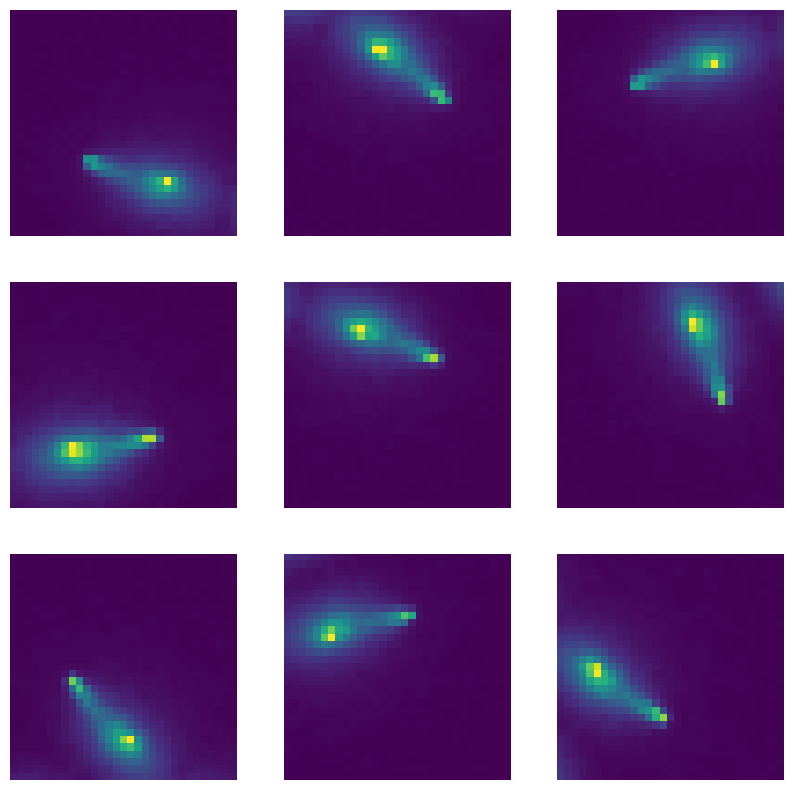

In [65]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

# Add the image to a batch.
image = cast(expand_dims(test_data[4380], 0), float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [69]:
test_data.shape

(10800, 31, 31, 1)

## CNN model


In [66]:
#create model
model = Sequential()
#add model layers
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(cam_side_length,cam_side_length,1)))
#model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.3))              
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
#model.add(Conv2D(128, kernel_size=3, activation='relu'))    #eliminate?
#model.add(Conv2D(128, kernel_size=3, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))     #eliminate?
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))  #softmax

#compile model using accuracy to measure model performance
model.compile(optimizer='Nadam', loss=BinaryCrossentropy(from_logits=True), metrics=['binary_accuracy'])  #SparseCategoricalCrossentropy(from_logits=True) BinaryCrossentropy(from_logits=True)
                                                                                        #'binary_crossentropy''categorical_crossentropy'
                                                                                        #metrics=[metricBinaryCrossentropy()] 'binary_accuracy'
#model.summary()

#train the model
history_callback = model.fit(train_data, train_label_ohe, batch_size=128, validation_data=(test_data, test_label_ohe), epochs=20) #_ohe
#pd.DataFrame(history_callback.history).plot(logy=True)

Epoch 1/20


c:\Users\Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


338/338 [==============================] - 37s 89ms/step - loss: nan - binary_accuracy: 0.5007 - val_loss: nan - val_binary_accuracy: 0.5000
Epoch 2/20
 67/338 [====>.........................] - ETA: 22s - loss: nan - binary_accuracy: 0.5000

KeyboardInterrupt: 

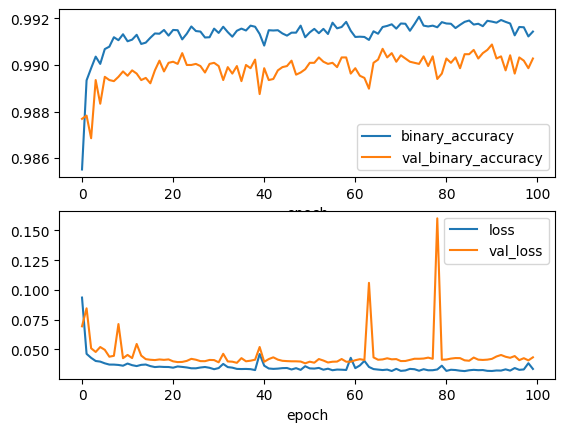

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history_callback.history['binary_accuracy'], label='binary_accuracy')
ax[0].plot(history_callback.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history_callback.history['loss'], label='loss')
ax[1].plot(history_callback.history['val_loss'], label='val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label_ohe) #ohe?
print('test_acc:', test_acc)

pred = model.predict(test_data)
pred = np.around(pred) 

pred_dec = np.dot(pred, np.array([0,1], dtype='float32'))
pred_lab = np.dot(test_label_ohe, np.array([0,1], dtype='float32'))
cm = confusion_matrix(pred_lab, pred_dec)
prec = precision_score(pred_lab, pred_dec)
reca = recall_score(pred_lab, pred_dec)
f1 = f1_score(pred_lab, pred_dec)
roc = roc_auc_score(pred_lab, pred_dec)

print('labelled :', np.where(pred_lab==1)[0].size)  
print('predicted :',  np.where(pred_dec==1)[0].size) 
print('true positive :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)).shape[0])     
print('false positive :', np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)).shape[0])     
print('false negative :', np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)).shape[0]) 
print('\n')
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)
print('roc score :', roc)
#
#print(np.where(pred_dec==1))
#print(np.where(pred_lab==1))

write_pdf = False
if write_pdf :
    pdf = PdfPages('./cnn.pdf')
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('TRUE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==0), np.where(pred_dec==1)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE positive')
        pdf.savefig(fig)
        plt.close()
    for evn in np.intersect1d(np.where(pred_lab==1), np.where(pred_dec==0)):
        fig = plt.figure()
        matrix = plt.pcolormesh(test_data[evn].reshape(cam_side_length,cam_side_length)*renormalisation)
        plt.colorbar(matrix)
        plt.title('FALSE negative')
        pdf.savefig(fig)
        plt.close()
    pdf.close()

338/338 [==============================] - 2s 5ms/step - loss: 0.0432 - binary_accuracy: 0.9903
test_acc: 0.9902777671813965
338/338 [==============================] - 2s 5ms/step
labelled : 164
predicted : 64
true positive : 62
false positive : 2
false negative : 102


confusion matrix :
[[10634     2]
 [  102    62]]
precision : 0.96875
recall : 0.3780487804878049
f1 score : 0.543859649122807
roc score : 0.6889303699355157


In [ ]:
save_model = False
if save_model:
    model_json = model.to_json()
    with open('model_highRoc.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('model_highRoc.h5')

In [ ]:
# 20 epochs - layers 32 64 128
# previous was:  test_acc: 0.9894444346427917
# predicted : 60
# true positive : 55

# 40 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 69
# true positive : 59

# 20 epochs - layers 64 128 256
# test_acc: 0.9888888597488403
# predicted : 54
# true positive : 49

# 20 epochs - layers 31 93 186
# test_acc: 0.9888888597488403
# predicted : 72
# true positive : 58

# 20 epochs - layers 32 64 128
# test_acc: 0.9893518686294556
# predicted : 63
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9889814853668213
# predicted : 57
# true positive : 51

# 30 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9887962937355042
# predicted : 57
# true positive : 50

# 40 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9892592430114746
# predicted : 58
# true positive : 53

# 50 epochs - layers 32 64 128 - Dropout 0.3
# test_acc: 0.9896296262741089
# predicted : 64
# true positive : 58

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy'
# test_acc: 0.9900000095367432              # probably starts overfitting
# predicted : 64
# true positive : 60

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True)
# test_acc: 0.9902777671813965              
# predicted : 69
# true positive : 64
# subsequent data augmentation
# test_acc: 0.9894444346427917              
# predicted : 62
# true positive : 56

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.988703727722168
# predicted : 52
# true positive : 47

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9894444346427917
# predicted : 56
# true positive : 53
# precision : 0.9464285714285714
# recall : 0.3231707317073171
# f1 score : 0.4818181818181818

# 40 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 70 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9887962937355042              
# predicted : 47
# true positive : 45
# precision : 0.9574468085106383
# recall : 0.27439024390243905
# f1 score : 0.42654028436018954
# roc score : 0.6371011016428328

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss=SparseCategoricalCrossentropy(from_logits=True) - DataAugmentation
# test_acc: 0.9885185360908508
# predicted : 48
# true positive : 44
# precision : 0.9166666666666666
# recall : 0.2682926829268293
# f1 score : 0.4150943396226415
# roc score : 0.6339583008466414

# 20 epochs - layers 32 64 128 - Dropout 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9891666769981384
# predicted : 49
# true positive : 48
# precision : 0.9795918367346939
# recall : 0.2926829268292683
# f1 score : 0.45070422535211263
# roc score : 0.6462944532604409

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.5 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.988611102104187
# predicted : 49
# true positive : 45
# precision : 0.9183673469387755
# recall : 0.27439024390243905
# f1 score : 0.4225352112676057
# roc score : 0.6370070813344463

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - model.add(Dense(64, activation='relu'))
# test_acc: 0.9881481528282166
# predicted : 42
# true positive : 39
# precision : 0.9285714285714286
# recall : 0.23780487804878048
# f1 score : 0.3786407766990291
# roc score : 0.6187614085618104

# 20 epochs - layers 32 64 128 - Dropout 0.3 eliminated(0.3) - loss='categorical_crossentropy' - DataAugmentation 
# test_acc: 0.988703727722168
# predicted : 50
# true positive : 46
# precision : 0.92
# recall : 0.2804878048780488
# f1 score : 0.4299065420560748
# roc score : 0.6400558618222512

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - sigmoid in Conv2D layers
# test_acc: 0.9850925803184509
# predicted : 39
# true positive : 19
# precision : 0.5428571428571428
# recall : 0.11585365853658537
# f1 score : 0.19095477386934676
# roc score : 0.5571746668011999

# 20 epochs - layers 32 64 128 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - padding='same'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 51
# true positive : 50
# precision : 0.9803921568627451
# recall : 0.3048780487804878
# f1 score : 0.4651162790697675
# roc score : 0.6523920142360506

# 100 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation
# test_acc: 0.9893518686294556
# predicted : 53
# true positive : 51
# precision : 0.9622641509433962
# recall : 0.31097560975609756
# f1 score : 0.4700460829493088
# roc score : 0.6553937845696622

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9897222518920898
# predicted : 65
# true positive : 59
# precision : 0.9076923076923077
# recall : 0.3597560975609756
# f1 score : 0.5152838427947598
# roc score : 0.679595987855328

# 20 epochs - layers 32 64 128 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9889814853668213
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 20 epochs - layers 32 64 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9880555272102356
# predicted : 47
# true positive : 41
# precision : 0.8723404255319149
# recall : 0.25
# f1 score : 0.3886255924170616
# roc score : 0.6247179390748402

# 20 epochs - layers 32 32 64 128 128 64 - Dropout 0.3 0.3 - loss='categorical_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9877777695655823
# predicted : 40
# true positive : 36
# precision : 0.9
# recall : 0.21951219512195122
# f1 score : 0.3529411764705882
# roc score : 0.6095680569442024

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss='binary_crossentropy' - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 52
# true positive : 48
# precision : 0.9230769230769231
# recall : 0.2926829268292683
# f1 score : 0.4444444444444444
# roc score : 0.6461534227978609

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 52
# true positive : 50
# precision : 0.9615384615384616
# recall : 0.3048780487804878
# f1 score : 0.46296296296296297
# roc score : 0.6523450040818572

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9887962937355042
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 64 128 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9892592430114746
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.989120364189148
# predicted : 56
# true positive : 52
# precision : 0.9285714285714286
# recall : 0.3170731707317073
# f1 score : 0.4727272727272727
# roc score : 0.6583485447490804

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 60
# true positive : 56
# precision : 0.9333333333333333
# recall : 0.34146341463414637
# f1 score : 0.5
# roc score : 0.6705436667003

# 20 epochs - layers 32 64 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 51
# true positive : 47
# precision : 0.9215686274509803
# recall : 0.2865853658536585
# f1 score : 0.43720930232558136
# roc score : 0.643104642310056

# 20 epochs - layers 32 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.988703727722168
# predicted : 44
# true positive : 43
# precision : 0.9772727272727273
# recall : 0.2621951219512195
# f1 score : 0.41346153846153844
# roc score : 0.6310505508214165

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 51
# true positive : 46
# precision : 0.9019607843137255
# recall : 0.2804878048780488
# f1 score : 0.427906976744186
# roc score : 0.6400088516680579

# 20 epochs - layers 32 64 64 128 64 - SpatialDropout2D 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9886574149131775
# predicted : 47
# true positive : 44
# precision : 0.9361702127659575
# recall : 0.2682926829268293
# f1 score : 0.4170616113744076
# roc score : 0.6340053110008348

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9888888597488403
# predicted : 49
# true positive : 47
# precision : 0.9591836734693877
# recall : 0.2865853658536585
# f1 score : 0.44131455399061026
# roc score : 0.6431986626184426

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9905555844306946
# predicted : 66
# true positive : 64
# precision : 0.9696969696969697
# recall : 0.3902439024390244
# f1 score : 0.5565217391304348
# roc score : 0.6950279309111255

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.3 0.3 - loss=BinaryCrossentropy(from_logits=True) - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9901388883590698
# predicted : 66
# true positive : 61
# precision : 0.9242424242424242
# recall : 0.3719512195121951
# f1 score : 0.5304347826086956
# roc score : 0.6857405589851311

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=64 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9895370602607727
# predicted : 59
# true positive : 56
# precision : 0.9491525423728814
# recall : 0.34146341463414637
# f1 score : 0.5022421524663677
# roc score : 0.6705906768544933

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.990231454372406
# predicted : 65
# true positive : 62
# precision : 0.9538461538461539
# recall : 0.3780487804878049
# f1 score : 0.5414847161572053
# roc score : 0.6888833597813225

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9884722232818604
# predicted : 66
# true positive : 53
# precision : 0.803030303030303
# recall : 0.3231707317073171
# f1 score : 0.4608695652173913
# roc score : 0.6609742338491456

# 20 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9893518686294556
# predicted : 64
# true positive : 57
# precision : 0.890625
# recall : 0.3475609756097561
# f1 score : 0.4999999999999999
# roc score : 0.6734514167255249

# 100 epochs - layers 32 64 64 128 64 - Dropout 0.5 - RobustScaler - loss=BinaryCrossentropy(from_logits=True) - batch_size=128 - binary_accuracy - sigmoid - DataAugmentation - optimizer='Nadam'
# test_acc: 0.9902777671813965
# predicted : 64
# true positive : 62
# precision : 0.96875
# recall : 0.3780487804878049
# f1 score : 0.543859649122807
# roc score : 0.6889303699355157



1/1 [==============================] - 0s 17ms/step
[[0. 1.]] [[0. 1.]]
cam n° : 5356


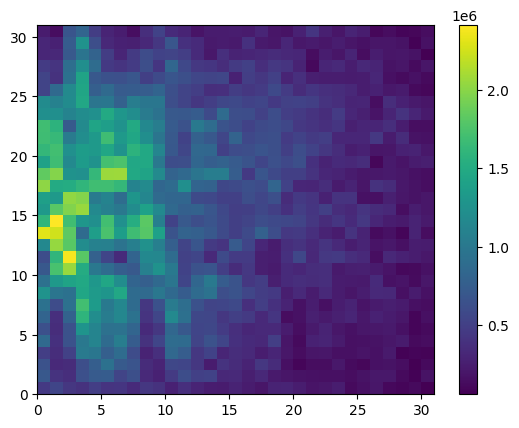

In [ ]:
ex = np.where(test_label==1)[0][91]
predex = model.predict(test_data[ex].reshape(-1, cam_side_length, cam_side_length, 1))
print(predex, np.around(predex))
print('cam n° :',ex)

cam = plt.pcolormesh(test_data[4303].reshape(cam_side_length, cam_side_length)*renormalisation)
plt.colorbar(cam)  